In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown

In [2]:
def lift(x, i, offset, vals):
    v = x[i + offset] * vals[0]
    if len(vals) > 1:
        return v + lift(x, i, offset + 1, vals[1:])
    else:
        return v

def bc_zero(x, i, n, offset, vals, verbose=False):
    io = i + offset
    if io >= n:
        return x.dtype.type(0.0)
    elif io < 0:
        if len(vals) > 1:
            return bc_zero(x, i, n, offset + 1, vals[1:])
        else:
            return x.dtype.type(0.0)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_zero(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_wrap(x, i, n, offset, vals, verbose=False):
    io = (i + offset) % n

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_wrap(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_const(x, i, n, offset, vals, verbose=False):
    io = i + offset
    if io >= n:
        io = n - 1
    elif io < 0:
        io = 0
    
    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_const(x, i, n, offset + 1, vals[1:])
    else:
        return v

def bc_symm(x, i, n, offset, vals, verbose=False):
    io = i + offset
    while io < 0 or io >= n:
        if io < 0:
            io = - (io + 1)
        elif io >= n:
            io = 2 * (n - 1) - (io - 1)

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_symm(x, i, n, offset + 1, vals[1:])
    else:
        return v


def bc_refl(x, i, n, offset, vals, verbose=False):
    io = i + offset
    while io < 0 or io >= n:
        if io < 0:
            io = -io
        elif io >= n:
            io = 2 * (n - 1) - io

    v = x[io] * vals[0]
    if len(vals) > 1:
        return v + bc_refl(x, i, n, offset + 1, vals[1:])
    else:
        return v

In [3]:
def bc_zero_adj_index(i, n):
    return n

def bc_wrap_adj_index(i, n):
    return i % n

def bc_const_adj_index(i, n):
    if i < 0:
        return 0
    else:
        return n-1

def bc_symm_adj_index(i, n):
    io = i
    while io >= n or io < 0:
        if io < 0:
            io = - (io + 1)
        elif io >= n:
            io = 2 * (n - 1) - (io - 1)
    return io

def bc_refl_adj_index(i, n):
    io = i
    while io >= n or io < 0:
        if io < 0:
            io = - io
        elif io >= n:
            io = 2 * (n - 1) - io
    return io

def bc_adj_loop(x, i_front, vals_r):
    n_vals = len(vals_r)

    i_start = max(0, i_front)
    i_end = min(len(x), i_front + n_vals)
    i_v = max(0, -i_front)

    v = 0.0
    for j in range(i_start, i_end):
        v += vals_r[i_v] * x[j]
        i_v += 1
    return v

def bc_adj_test(x, i_front, vals_r):
    n_vals = len(vals_r)

    i_start = max(0, i_front)
    i_end = min(len(x), i_front + n_vals)
    i_v = max(0, -i_front)

    print(i_start, i_end, i_v, "\n")

    v = 0.0
    for j in range(i_start, i_end):
        print(vals_r[i_v], x[j])
        v += vals_r[i_v] * x[j]
        i_v += 1
    return v

def bc_adj_recursive(x, i, vals_r):
    n_vals = len(vals_r)
    if n_vals == 0 or i == len(x):
        return 0.0
    if i < 0:
        return bc_adj_recursive(x, i + 1, vals_r[1:])
    v = vals_r[0] * x[i] + bc_adj_recursive(x, i + 1, vals_r[1:])
    return v

In [4]:
x = np.arange(32)
vals = np.arange(4) * 10

i_front = -5-1

bc_adj_test(x, i_front, vals)

bc_adj_recursive(x, i_front, vals)

0 -2 6 



0.0

In [5]:
class update_d:

    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def forward(self, s, d, bc, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(min(self.n_front, nd)):
            d[i] += bc(s, i, ns, self.offset, vals, verbose=verbose)

        for i in range(self.n_front, nd - self.n_back):
            d[i] += lift(s, i, self.offset, vals)

        for i in range(max(nd - self.n_back, 0), nd):
            d[i] += bc(s, i, ns, self.offset, vals, verbose=verbose)

    def inverse(self, s, d, bc, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(min(self.n_front, nd)):
            d[i] -= bc(s, i, ns, self.offset, vals, verbose=verbose)

        for i in range(self.n_front, nd - self.n_back):
            d[i] -= lift(s, i, self.offset, vals)

        for i in range(max(nd - self.n_back, 0), nd):
            d[i] -= bc(s, i, ns, self.offset, vals, verbose=verbose)

    def forward_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        ns = len(s)
        nd = len(d)

        vals = self.vals.astype(s.dtype)
        offset = self.offset
        
        vals_r = self.vals[::-1].astype(s.dtype).copy()
        offset_r = self.offset_r

        n_vals = len(vals)

        i_front = 1 - n_vals
        for i in range(offset, 0):
            io = bc_adj_index(i, ns)
            if io != ns and io != i:
                s[io] += bc_adj_recursive(d, i_front, vals_r)
            i_front += 1

        for i in range(min(self.n_front_r, ns)):
            s[i] += bc_zero(d, i, nd, offset_r, vals_r)
        for i in range(self.n_front_r, nd - self.n_back_r):
            s[i] += lift(d, i, offset_r, vals_r)
        for i in range(max(nd - self.n_back_r, 0), ns):
            s[i] += bc_zero(d, i, nd, offset_r, vals_r)

        i_front = nd + offset_r
        for i in range(nd, nd - offset_r):
            io = bc_adj_index(i, ns)
            if io != ns and io != i:
                s[io] += bc_adj_recursive(d, i_front, vals_r)
            i_front += 1

    def inverse_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        ns = len(s)
        nd = len(d)

        vals = self.vals.astype(s.dtype)
        offset = self.offset
        
        vals_r = self.vals[::-1].astype(s.dtype).copy()
        offset_r = self.offset_r

        n_vals = len(vals)

        # i_back = 1
        # for i in range(offset, 0):
        #     io = bc_adj_index(i, ns)
        #     if io != ns and io != i:
        #         s[io] -= bc_front_loop(d, i_back, vals_r)
        #     i_back += 1

        i_front = 1 - n_vals
        for i in range(offset, 0):
            io = bc_adj_index(i, ns)
            if io != ns and io != i:
                s[io] -= bc_adj_recursive(d, i_front, vals_r)
            i_front += 1

        for i in range(min(self.n_front_r, ns)):
            s[i] -= bc_zero(d, i, nd, offset_r, vals_r)
        for i in range(self.n_front_r, nd - self.n_back_r):
            s[i] -= lift(d, i, offset_r, vals_r)
        for i in range(max(nd - self.n_back_r, 0), ns):
            s[i] -= bc_zero(d, i, nd, offset_r, vals_r)

        i_front = nd + offset_r
        for i in range(nd, nd - offset_r):
            io = bc_adj_index(i, ns)
            if io != ns and io != i:
                s[io] -= bc_adj_recursive(d, i_front, vals_r)
            i_front += 1

class update_s:

    def __init__(self, offset, vals):
        self.vals = np.asarray(vals, dtype=np.float64).copy()
        self.offset = offset
        self.n_front = 0 if offset > 0 else -offset

        n_vals = len(vals)
        max_off = n_vals - 1 + offset
        self.n_back = 0 if max_off < 0 else max_off

        self.offset_r = -max_off
        self.n_front_r = 0 if self.offset_r > 0 else -self.offset_r
        
        max_off_r = n_vals - 1 + self.offset_r
        self.n_back_r = 0 if max_off_r < 0 else max_off_r

    def forward(self, s, d, bc, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(min(self.n_front, ns)):
            s[i] += bc(d, i, nd, self.offset, vals, verbose=verbose)

        for i in range(self.n_front, nd - self.n_back):
            s[i] += lift(d, i, self.offset, vals)

        for i in range(max(nd - self.n_back, 0), ns):
            s[i] += bc(d, i, nd, self.offset, vals, verbose=verbose)

    def inverse(self, s, d, bc, verbose=False) -> None:
        ns = len(s)
        nd = len(d)
        vals = self.vals.astype(s.dtype)

        for i in range(min(self.n_front, ns)):
            s[i] -= bc(d, i, nd, self.offset, vals, verbose=verbose)

        for i in range(self.n_front, nd - self.n_back):
            s[i] -= lift(d, i, self.offset, vals)

        for i in range(max(nd - self.n_back, 0), ns):
            s[i] -= bc(d, i, nd, self.offset, vals, verbose=verbose)

    def forward_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        ns = len(s)
        nd = len(d)

        vals = self.vals.astype(s.dtype)
        offset = self.offset
        
        vals_r = self.vals[::-1].astype(s.dtype).copy()
        offset_r = self.offset_r

        n_vals = len(vals)

        i_front = 1 - n_vals
        for i in range(offset, 0):
            io = bc_adj_index(i, nd)
            if io != nd and io != i:
                d[io] += bc_adj_recursive(s, i_front, vals_r)
            i_front += 1

        for i in range(min(self.n_front_r, nd)):
            d[i] += bc_zero(s, i, ns, offset_r, vals_r)
        for i in range(self.n_front_r, nd - self.n_back_r):
            d[i] += lift(s, i, offset_r, vals_r)
        for i in range(max(nd - self.n_back_r, 0), nd):
            d[i] += bc_zero(s, i, ns, offset_r, vals_r)

        i_front = nd + offset_r
        for i in range(nd, ns - offset_r):
            io = bc_adj_index(i, nd)
            if io != nd and io != i:
                d[io] += bc_adj_recursive(s, i_front, vals_r)
            i_front += 1

    def inverse_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        ns = len(s)
        nd = len(d)

        vals = self.vals.astype(s.dtype)
        offset = self.offset

        vals_r = self.vals[::-1].astype(s.dtype).copy()
        offset_r = self.offset_r

        n_vals = len(vals)

        i_front = 1 - n_vals
        for i in range(offset, 0):
            io = bc_adj_index(i, nd)
            if io != nd and io != i:
                d[io] -= bc_adj_recursive(s, i_front, vals_r)
            i_front += 1

        for i in range(min(self.n_front_r, nd)):
            d[i] -= bc_zero(s, i, ns, offset_r, vals_r)
        for i in range(self.n_front_r, nd - self.n_back_r):
            d[i] -= lift(s, i, offset_r, vals_r)
        for i in range(max(nd - self.n_back_r, 0), nd):
            d[i] -= bc_zero(s, i, ns, offset_r, vals_r)

        i_front = nd + offset_r
        for i in range(nd, ns - offset_r):
            io = bc_adj_index(i, nd)
            if io != nd and io != i:
                d[io] -= bc_adj_recursive(s, i_front, vals_r)
            i_front += 1

class scale:
    def __init__(self, val):
        self._val = val

    def forward(self, s, d, bc, verbose=False) -> None:
        for i in range(len(d)):
            d[i] /= self._val
        for i in range(len(s)):
            s[i] *= self._val

    def inverse(self, s, d, bc, verbose=False) -> None:
        for i in range(len(d)):
            d[i] *= self._val
        for i in range(len(s)):
            s[i] /= self._val

    def forward_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        self.forward(s, d, None)

    def inverse_adj(self, s, d, bc_adj_index, verbose=False) -> None:
        self.inverse(s, d, None)



In [6]:
def forward_transform(wvlt, x, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = bc_wrap
    elif mode == 'zero':
        bc = bc_zero
    elif mode == 'constant':
        bc = bc_const
    elif mode == 'symmetric':
        bc = bc_symm
    elif mode == 'reflect':
        bc = bc_refl
    else:
        raise ValueError(f"Mode: {mode} is not valid.")

    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.forward(s, d, bc, verbose=verbose)

    return s, d


def inverse_transform(wvlt, s, d, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = bc_wrap
    elif mode == 'zero':
        bc = bc_zero
    elif mode == 'constant':
        bc = bc_const
    elif mode == 'symmetric':
        bc = bc_symm
    elif mode == 'reflect':
        bc = bc_refl
    else:
        raise ValueError(f"Mode: {mode} is not valid.")

    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.inverse(s, d, bc, verbose=verbose)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

def forward_transform_adj(wvlt, s, d, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = bc_wrap_adj_index
    elif mode == 'zero':
        bc = bc_zero_adj_index
    elif mode == 'constant':
        bc = bc_const_adj_index
    elif mode == 'symmetric':
        bc = bc_symm_adj_index
    elif mode == 'reflect':
        bc = bc_refl_adj_index
    else:
        raise ValueError(f"Mode: {mode} is not valid.")

    s = s.copy()
    d = d.copy()

    for step in wvlt.steps[::-1]:
        step.forward_adj(s, d, bc, verbose=verbose)

    x = np.empty(len(s) + len(d), dtype=s.dtype)
    x[::2] = s
    x[1::2] = d
    return x

def inverse_transform_adj(wvlt, x, mode="periodic", verbose=False):
    if mode == 'periodic':
        bc = bc_wrap_adj_index
    elif mode == 'zero':
        bc = bc_zero_adj_index
    elif mode == 'constant':
        bc = bc_const_adj_index
    elif mode == 'symmetric':
        bc = bc_symm_adj_index
    elif mode == 'reflect':
        bc = bc_refl_adj_index
    else:
        raise ValueError(f"Mode: {mode} is not valid.")

    s = x[::2].copy()
    d = x[1::2].copy()

    for step in wvlt.steps:
        step.inverse_adj(s, d, bc, verbose=verbose)

    return s, d

In [11]:
class TestDWavelet:
    steps = (
        update_d(-3, [2, 3, 5, 8, 11, 15, 20]),
    )

class TestSWavelet:
    steps = (
        update_s(-3, [2, 3, 5, 8, 11, 15, 20]),
    )

class TestMultWavelet:
    steps = (
        update_d(-3, [2, 3, 5, 8, 11, 15, 20]),
        update_s(3, [1, 2, 3, 4, 5, 6, 7]),
        update_d(-5, [2, 3]),
    )

class Daubechies2:
    steps = (
        update_d(0, [-1.73205080756887729352744634150587236694280525381038062805581]),
        update_s(0, [
            0.433012701892219323381861585376468091735701313452595157013952,
            -0.0669872981077806766181384146235319082642986865474048429860483
        ]),
        update_d(-1, [1]),
        scale(1.93185165257813657349948639945779473526780967801680910080469)
    )

In [12]:
modes = [
    "zero",
    "constant",
    "periodic",
    "symmetric",
    "reflect",
]

In [13]:
rng = np.random.default_rng(472819)

n = 100
x_e = rng.standard_normal(n)
x_o = rng.standard_normal(n+1)

y_e = rng.standard_normal(n)
y_o = rng.standard_normal(n+1)

su_e = rng.standard_normal(n//2)
du_e = rng.standard_normal(n//2)

su_o = rng.standard_normal(n//2 + 1)
du_o = rng.standard_normal(n//2)

sv_e = rng.standard_normal(n//2)
dv_e = rng.standard_normal(n//2)

sv_o = rng.standard_normal(n//2 + 1)
dv_o = rng.standard_normal(n//2)

In [14]:

header = """
| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |"""

output = []
for wvlt in [TestDWavelet, TestSWavelet, TestMultWavelet, Daubechies2]:
    output.append(f"### {wvlt.__qualname__}")
    
    output.append("#### Forward & Inverse")
    output.append(header)
    for mode in modes:

        sx_e, dx_e = forward_transform(wvlt, x_e, mode=mode)
        x_e2 = inverse_transform(wvlt, sx_e, dx_e, mode=mode)
        
        sx_o, dx_o = forward_transform(wvlt, x_o, mode=mode)
        x_o2 = inverse_transform(wvlt, sx_o, dx_o, mode=mode)

        out = f"|{mode} |  {np.allclose(x_e, x_e2)} | {np.allclose(x_o, x_o2)} |"
        output.append(out)

    output.append("#### Adjoint Forward & Inverse")
    output.append(header)
    for mode in modes:
        sx_e, dx_e = inverse_transform_adj(wvlt, x_e, mode=mode)
        x_e2 = forward_transform_adj(wvlt, sx_e, dx_e, mode=mode)
        
        sx_o, dx_o = inverse_transform_adj(wvlt, x_o, mode=mode)
        x_o2 = forward_transform_adj(wvlt, sx_o, dx_o, mode=mode)

        out = f"|{mode} |  {np.allclose(x_e, x_e2)} | {np.allclose(x_o, x_o2)} |"
        output.append(out)

    output.append("#### Forward Adjoint")
    output.append(header)
    for mode in modes:
        sx_e, dx_e = forward_transform(wvlt, x_e, mode=mode)
        u_adj = forward_transform_adj(wvlt, su_e, du_e, mode=mode)
    
        v1_e = sx_e @ su_e + dx_e @ du_e
        v2_e = x_e @ u_adj
    
        sx_o, dx_o = forward_transform(wvlt, x_o, mode=mode)
        u_adj = forward_transform_adj(wvlt, su_o, du_o, mode=mode)
    
        v1_o = sx_o @ su_o + dx_o @ du_o
        v2_o = x_o @ u_adj

        out = f"|{mode} |  {np.allclose(v1_e, v2_e)} | {np.allclose(v1_o, v2_o)} |"
        output.append(out)
        
    output.append("#### Inverse Adjoint")
    output.append(header)

    for mode in modes:
        sx_e, dx_e = inverse_transform_adj(wvlt, x_e, mode=mode)
        u_adj = inverse_transform(wvlt, su_e, du_e, mode=mode)
    
        v1_e = sx_e @ su_e + dx_e @ du_e
        v2_e = x_e @ u_adj
    
        sx_o, dx_o = inverse_transform_adj(wvlt, x_o, mode=mode)
        u_adj = inverse_transform(wvlt, su_o, du_o, mode=mode)
    
        v1_o = sx_o @ su_o + dx_o @ du_o
        v2_o = x_o @ u_adj

        out = f"|{mode} |  {np.allclose(v1_e, v2_e)} | {np.allclose(v1_o, v2_o)} |"
        output.append(out)
        
    output.append("#### Inverse Adjoint @ Forward")
    output.append(header)
    
    for mode in modes:
        sx_e, dx_e = forward_transform(wvlt, x_e, mode=mode)
        sy_e, dy_e = inverse_transform_adj(wvlt, y_e, mode=mode)
    
        v1_e = sx_e @ sy_e + dx_e @ dy_e
        v2_e = x_e @ y_e
        
        sx_o, dx_o = forward_transform(wvlt, x_o, mode=mode)
        sy_o, dy_o = inverse_transform_adj(wvlt, y_o, mode=mode)
    
        v1_o = sx_o @ sy_o + dx_o @ dy_o
        v2_o = x_o @ y_o

        out = f"|{mode} |  {np.allclose(v1_e, v2_e)} | {np.allclose(v1_o, v2_o)} |"
        output.append(out)
        
    output.append("#### Inverse @ Forward Adjoint")
    output.append(header)
    
    for mode in modes:
        u_e = inverse_transform(wvlt, su_e, du_e, mode=mode)
        v_e = forward_transform_adj(wvlt, sv_e, dv_e, mode=mode)
    
        v1_e = su_e @ sv_e + du_e @ dv_e
        v2_e = u_e @ v_e
    
        u_o = inverse_transform(wvlt, su_o, du_o, mode=mode)
        v_o = forward_transform_adj(wvlt, sv_o, dv_o, mode=mode)
    
        v1_o = su_o @ sv_o + du_o @ dv_o
        v2_o = u_o @ v_o

        out = f"|{mode} |  {np.allclose(v1_e, v2_e)} | {np.allclose(v1_o, v2_o)} |"
        output.append(out)

output = "\n".join(output)

Markdown(output)

### TestDWavelet
#### Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Adjoint Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint @ Forward

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse @ Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
### TestSWavelet
#### Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Adjoint Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint @ Forward

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse @ Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
### TestMultWavelet
#### Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Adjoint Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint @ Forward

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse @ Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
### Daubechies2
#### Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Adjoint Forward & Inverse

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse Adjoint @ Forward

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |
#### Inverse @ Forward Adjoint

| Boundary Condition | Even Passed | Odd Passed |
| ------------------ | ----------- | ---------- |
|zero |  True | True |
|constant |  True | True |
|periodic |  True | True |
|symmetric |  True | True |
|reflect |  True | True |

## verify transformation adjoint matrices

In [15]:
def get_mats(wvlt, mode, n, verbose=1):
    fwd_mats = []
    fwd_adj_mats = []

    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        nd = len(e)//2
        ns = len(e) - nd
        es = e[:ns]
        ed = e[ns:]
        
        # s, d = forward_transform(TestDWavelet, e, mode=mode)
        # for_mats.append(np.r_[s, d])
        s, d = forward_transform(wvlt, e, mode=mode, verbose=verbose)
        fwd_mats.append(np.r_[s, d])
    
        fwd_adj_mats.append(forward_transform_adj(wvlt, es, ed, mode=mode, verbose=verbose))

        verbose = 0

    fwd_mats = np.stack(fwd_mats, axis=1)
    fwd_adj_mats = np.stack(fwd_adj_mats, axis=1)
    return fwd_mats, fwd_adj_mats

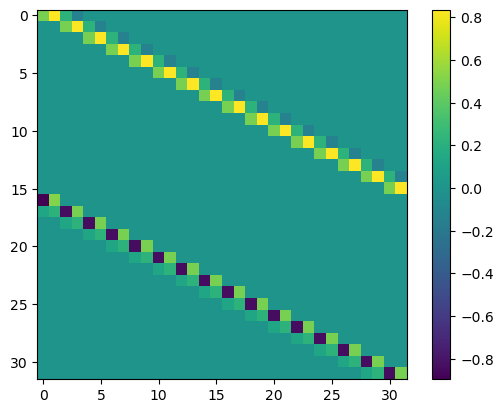

In [26]:
n = 32
fwd_mats, fwd_adj_mats = get_mats(Daubechies2, 'zero', n=n)
plt.imshow(fwd_mats)
# plt.imshow(fwd_mats.T)
plt.colorbar()

In [37]:
ii = -1
print(fwd_mats[:16, ii])
print(fwd_mats[16:, ii])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.12940952  0.8365163 ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.48296291]


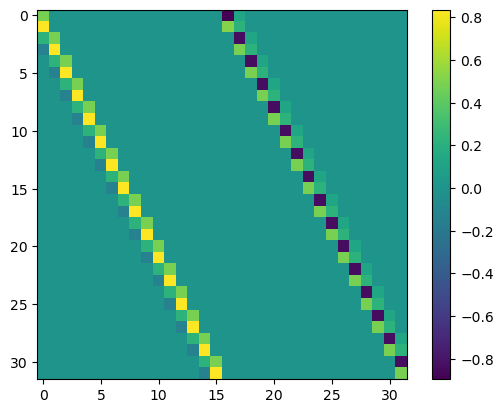

In [28]:
plt.imshow(fwd_adj_mats)
# plt.imshow(fwd_adj_mats)
plt.colorbar()

In [25]:
fwd_adj_mats[15]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.12940952,  0.8365163 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.48296291,  0.22414387,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])